**Predicting Illicit Drug Use Using Supervised Learning**
=========================================================

**1\. Problem Statement**
-------------------------

### **Objective**

The goal of this project is to leverage supervised machine learning to predict whether an individual is a user of illicit drugs based on demographic attributes, personality traits, and behavioral characteristics. This is a **binary classification task**, where the target variable indicates drug use:

-   `1` = User

-   `0` = Non-user

### **Why It Matters**

Substance abuse is a significant public health issue with far-reaching **social, psychological, and economic consequences**. By identifying strong predictors of drug use and evaluating model performance, this project aims to:

1.  Provide actionable insights for **targeted interventions**.

2.  Inform **educational programs and public health policies**.

3.  Develop a model to accurately predict if an individual is at risk for drug use/abuse, using key metrics such as **precision, recall, and F1-score**.

**2\. Models Used**
-------------------

The following machine learning models were evaluated for their ability to predict drug use:

1.  **Logistic Regression** - Simple and interpretable for identifying significant predictors.

2.  **Random Forest** - Handles non-linear relationships and provides feature importance analysis.

3.  **Support Vector Machine (SVM)** - Suitable for high-dimensional data and non-linear boundaries.

4.  **k-Nearest Neighbors (KNN)** - Captures local patterns and is easy to implement.

In [187]:
# Import required libraries
# Import necessary libraries
from ucimlrepo import fetch_ucirepo  # Fetch dataset from UCI ML Repository
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns  
import matplotlib.pyplot as plt

# Scikit-Learn modules for machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

**3\. Dataset Information**
---------------------------

### **Data Source**

The data used for this project is the **"Drug Consumption (Quantified)"** dataset:

-   **Citation**: Fehrman, E., Egan, V., & Mirkes, E. (2015). Drug Consumption (Quantified) [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5TC7S.

In [188]:
# Fetch dataset
drug_consumption_quantified = fetch_ucirepo(id=373)

# Load data as Pandas DataFrames
X = drug_consumption_quantified.data.features
y = drug_consumption_quantified.data.targets

# Merge features and targets into a single DataFrame
df = pd.concat([X, y], axis=1)

### **Dataset Overview**

-   **Number of Samples**: 1,885

-   **Number of Features**: 31 (12 numerical, 19 categorical)

-   **Target Variable**: `drug_use` (Binary: `1`=User, `0`=Non-user)

### **Feature Categories**

1.  **Demographics**: Age, Gender, Education, Country, Ethnicity

2.  **Personality Traits**: Big Five Personality Scores (nscore, escore, oscore, ascore, cscore)

3.  **Behavioral Characteristics**: Impulsivity Score, Sensation-Seeking Score

4.  **Substance Use Variables**: Frequency of use for 19 different substances

In [189]:
# Check the structure of the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 31 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1885 non-null   float64
 1   gender     1885 non-null   float64
 2   education  1885 non-null   float64
 3   country    1885 non-null   float64
 4   ethnicity  1885 non-null   float64
 5   nscore     1885 non-null   float64
 6   escore     1885 non-null   float64
 7   oscore     1885 non-null   float64
 8   ascore     1885 non-null   float64
 9   cscore     1885 non-null   float64
 10  impuslive  1885 non-null   float64
 11  ss         1885 non-null   float64
 12  alcohol    1885 non-null   object 
 13  amphet     1885 non-null   object 
 14  amyl       1885 non-null   object 
 15  benzos     1885 non-null   object 
 16  caff       1885 non-null   object 
 17  cannabis   1885 non-null   object 
 18  choc       1885 non-null   object 
 19  coke       1885 non-null   object 
 20  crack   

In [190]:
# Dataset Shape and Data Types
print("Dataset Shape:", df.shape)
print("\nData Types:")
print(df.dtypes.value_counts())

# Summary of numerical columns
df.describe()

# Count unique values in categorical columns
categorical_columns = df.select_dtypes(include='object').columns
for col in categorical_columns:
    print(f"{col}: {df[col].nunique()} unique values")


Dataset Shape: (1885, 31)

Data Types:
object     19
float64    12
Name: count, dtype: int64
alcohol: 7 unique values
amphet: 7 unique values
amyl: 7 unique values
benzos: 7 unique values
caff: 7 unique values
cannabis: 7 unique values
choc: 7 unique values
coke: 7 unique values
crack: 7 unique values
ecstasy: 7 unique values
heroin: 7 unique values
ketamine: 7 unique values
legalh: 7 unique values
lsd: 7 unique values
meth: 7 unique values
mushrooms: 7 unique values
nicotine: 7 unique values
semer: 5 unique values
vsa: 7 unique values


**4\. Data Cleaning**
---------------------

### **4.1 Steps Taken**

1.  **Checked for missing values** (None found).

2.  **Fixed a typo** (`impuslive` → `impulsive`).

3.   **Checking for significant outliers**

4. **Dropped irrelevant columns** (Removed `semer`, a fictitious drug meant to identify over-reporting).

5. **Converted drug use into a binary target variable (**`**drug_use**`**)**. 

6. **Mapped categorical features** to improve readability (e.g., age groups, education levels, ethnicity).

In [191]:
# Check for missing values
print(df.isnull().sum())

age          0
gender       0
education    0
country      0
ethnicity    0
nscore       0
escore       0
oscore       0
ascore       0
cscore       0
impuslive    0
ss           0
alcohol      0
amphet       0
amyl         0
benzos       0
caff         0
cannabis     0
choc         0
coke         0
crack        0
ecstasy      0
heroin       0
ketamine     0
legalh       0
lsd          0
meth         0
mushrooms    0
nicotine     0
semer        0
vsa          0
dtype: int64


In [192]:
# Fix column name
df = df.rename(columns={'impuslive': 'impulsive'})
ogDfLen = len(df)

Checking for outliers

In [193]:
# Define numerical columns for further analysis of outliers
numerical_columns = df.select_dtypes(include=['float64']).columns

In [194]:
# Calculate Z-scores for numerical columns
z_scores = np.abs(stats.zscore(df[numerical_columns]))

# Identify outliers
outliers = (z_scores > 3).any(axis=1)
print(f"Number of outliers detected: {outliers.sum()}")
print(df[outliers])

Number of outliers detected: 66
          age   gender  education  country  ethnicity   nscore   escore  \
13    1.82213  0.48246   -0.05921  0.24923   -0.31685 -0.79151  0.80523   
23    1.09449 -0.48246   -1.73790  0.96082   -0.31685  1.60383 -3.27393   
26    1.82213  0.48246   -1.22751  0.24923   -0.31685 -0.05188 -1.63340   
99   -0.07854  0.48246    0.45468  0.96082   -0.31685 -0.67825  3.00537   
134  -0.07854  0.48246    1.16365  0.96082    0.12600  3.27393 -1.50796   
...       ...      ...        ...      ...        ...      ...      ...   
1789 -0.95197 -0.48246    0.45468 -0.57009   -0.31685  0.62967 -1.50796   
1805 -0.95197  0.48246    1.16365  0.96082   -1.10702  0.41667 -0.80615   
1844 -0.95197  0.48246    0.45468 -0.57009   -0.31685  1.60383 -0.94779   
1846  1.09449 -0.48246   -0.05921 -0.57009   -1.10702 -1.05308 -0.94779   
1857 -0.95197 -0.48246   -0.61113 -0.57009   -0.31685  1.72012  0.32197   

       oscore   ascore   cscore  ...  ecstasy  heroin ketamine lega

In [195]:
# Drop outliers
df = df[~outliers]
newDfLen = len(df)

# Number of outliers dropped
print(f"Number of outliers dropped: {ogDfLen - newDfLen}")

Number of outliers dropped: 66


In [196]:
# Drop bad samples based on the dataset description, fictitious drug to weed out those who over report drug use
# List of drug use codes to filter out
drug_user = ['CL3', 'CL4', 'CL5', 'CL6']

# Store the original number of rows
original_row_count = len(df)

# Create a boolean mask to identify rows where 'semer' is NOT in the drug_user list
mask = []
for value in df['semer']:
    if value in drug_user:
        mask.append(False)  # Drop this row
    else:
        mask.append(True)   # Keep this row

# Drop semer column
df = df.drop(columns=['semer'])

# Apply the mask to filter the dataframe
df = df.loc[mask]

# Calculate the number of rows dropped
rows_dropped = original_row_count - len(df)
print(f"Number of rows dropped: {rows_dropped}")

Number of rows dropped: 3


In [197]:
# Preview the dataset
print(df.head())

       age   gender  education  country  ethnicity   nscore   escore   oscore  \
0  0.49788  0.48246   -0.05921  0.96082    0.12600  0.31287 -0.57545 -0.58331   
1 -0.07854 -0.48246    1.98437  0.96082   -0.31685 -0.67825  1.93886  1.43533   
2  0.49788 -0.48246   -0.05921  0.96082   -0.31685 -0.46725  0.80523 -0.84732   
3 -0.95197  0.48246    1.16365  0.96082   -0.31685 -0.14882 -0.80615 -0.01928   
4  0.49788  0.48246    1.98437  0.96082   -0.31685  0.73545 -1.63340 -0.45174   

    ascore   cscore  ...  crack  ecstasy heroin ketamine legalh  lsd meth  \
0 -0.91699 -0.00665  ...    CL0      CL0    CL0      CL0    CL0  CL0  CL0   
1  0.76096 -0.14277  ...    CL0      CL4    CL0      CL2    CL0  CL2  CL3   
2 -1.62090 -1.01450  ...    CL0      CL0    CL0      CL0    CL0  CL0  CL0   
3  0.59042  0.58489  ...    CL0      CL0    CL0      CL2    CL0  CL0  CL0   
4 -0.30172  1.30612  ...    CL0      CL1    CL0      CL0    CL1  CL0  CL0   

  mushrooms nicotine  vsa  
0       CL0      CL2  

In [198]:
df.columns

Index(['age', 'gender', 'education', 'country', 'ethnicity', 'nscore',
       'escore', 'oscore', 'ascore', 'cscore', 'impulsive', 'ss', 'alcohol',
       'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 'choc', 'coke', 'crack',
       'ecstasy', 'heroin', 'ketamine', 'legalh', 'lsd', 'meth', 'mushrooms',
       'nicotine', 'vsa'],
      dtype='object')

### **Understand the Target Variable**

Before diving into predictors, analyze the distribution of the target variable (`y`).

In [199]:
# Define a list of drugs (update based on your analysis)
drugs = ['cannabis', 'coke', 'crack', 'heroin', 'meth', 'ecstasy', 
        'lsd', 'amyl', 'ketamine', 'mushrooms', 'vsa']

# Use at least once in last year
drug_user = ['CL3', 'CL4', 'CL5', 'CL6']

# Define a binary target variable for any drug use in the last year
def check_drug_use(row):
    for user in drug_user:  # Iterate over the drug_user codes
        if user in row.values:  # Check if the code is in the row's values
            return 1  # Return 1 if a match is found
    return 0  # Return 0 if no matches are found

# Apply the function only to the specified drug columns
df['drug_use'] = df[drugs].apply(check_drug_use, axis=1)

dfDrugUse = df.drop(columns={'alcohol',
       'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 'choc', 'coke', 'crack',
       'ecstasy', 'heroin', 'ketamine', 'legalh', 'lsd', 'meth', 'mushrooms',
       'nicotine', 'vsa'})
dfDrugUse.head()


,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impulsive,ss,drug_use
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,1
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,1
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,1


### **Overview of the Target Variable**

-   Start by checking the distribution of the binary target variable to ensure no severe class imbalance.

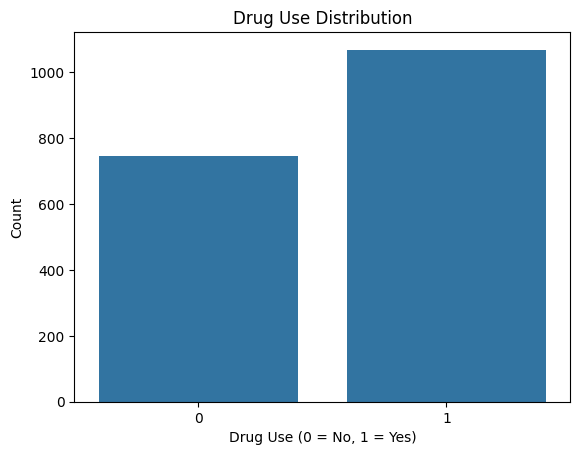

In [200]:
# Plot the new binary target variable
sns.countplot(x=df['drug_use'], y=None, hue=None, data=df)
plt.title("Drug Use Distribution")
plt.xlabel("Drug Use (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

In [201]:
# Check class distribution
print(df['drug_use'].value_counts(normalize=True))


drug_use
1    0.588656
0    0.411344
Name: proportion, dtype: float64


### **4.2 Data Cleaning Summary**

-   **No missing values** found.

-   **66 outliers removed**.

-   **Slight class imbalance** (Users = 58.7%, Non-users = 41.3%).

-   **3 rows dropped** because of semer use

### **Create a Mapped DataFrame for Visualizations**

Copy the original `df` to a new DataFrame, `dfMapped`, and apply the mappings only to this new DataFrame.

In [202]:
# Mapping age values to age groups
age_mapping = {
    -0.95197: "18-24",
    -0.07854: "25-34",
     0.49788: "35-44",
     1.09449: "45-54",
     1.82213: "55-64",
     2.59171: "65+"
}

gender_mapping = {
    0.48246: "Female",
   -0.48246: "Male"
}

education_mapping = {
    -2.43591: "Left before 16",
    -1.73790: "Left at 16",
    -1.43719: "Left at 17",
    -1.22751: "Left at 18",
    -0.61113: "Some college",
    -0.05921: "Professional cert",
     0.45468: "University degree",
     1.16365: "Masters degree",
     1.98437: "Doctorate"
}

country_mapping = {
    -0.09765: "Australia",
     0.24923: "Canada",
    -0.46841: "New Zealand",
    -0.28519: "Other",
     0.21128: "Ireland",
     0.96082: "UK",
    -0.57009: "USA"
}

ethnicity_mapping = {
    -0.50212: "Asian",
    -1.10702: "Black",
     1.90725: "Mixed-Black/Asian",
     0.12600: "Mixed-White/Asian",
    -0.22166: "Mixed-White/Black",
     0.11440: "Other",
    -0.31685: "White"
}

In [203]:
# Create a separate DataFrame for mapped values
dfMapped = df.copy()

# Apply mappings to the copied DataFrame for visualizations
dfMapped['age'] = dfMapped['age'].map(age_mapping)
dfMapped['gender'] = dfMapped['gender'].map(gender_mapping)
dfMapped['education'] = dfMapped['education'].map(education_mapping)
dfMapped['country'] = dfMapped['country'].map(country_mapping)
dfMapped['ethnicity'] = dfMapped['ethnicity'].map(ethnicity_mapping)


**5\. Exploratory Data Analysis (EDA)**
--------------------------------------

Exploratory Data Analysis (EDA) helps us understand patterns in the dataset before applying machine learning models. 
In this section, we will:
- Analyze demographic and personality feature distributions.
- Check correlations between features.
- Identify potential biases and trends in drug use.

### **5.1 Feature Distributions**

   **a. Demographics vs. Drug Use**: Age, gender, education, ethnicity, and country distributions.

   **b. Personality Traits**: Box plots for Big Five traits.

   **c. Correlation Analysis**: Heatmap of numerical feature correlations.

   **d. Pairwise Relationships**: Scatter plots of selected features.

a. Demographics

Relationships Between Features and `illicit_drug_use`:

In [212]:
for col in ['age', 'gender', 'education']:
    print(f"Distribution of {col} by illicit_drug_use:")
    print(dfMapped.groupby([col, 'drug_use']).size().unstack())


Distribution of age by illicit_drug_use:
drug_use    0    1
age               
18-24      78  535
25-34     201  266
35-44     194  148
45-54     197   88
55-64      61   30
65+        16    2
Distribution of gender by illicit_drug_use:
drug_use    0    1
gender            
Female    506  402
Male      241  667
Distribution of education by illicit_drug_use:
drug_use             0    1
education                  
Doctorate           52   36
Left at 16          47   51
Left at 17           9   19
Left at 18          25   71
Left before 16       9   19
Masters degree     177   98
Professional cert  129  131
Some college        65  416
University degree  234  228


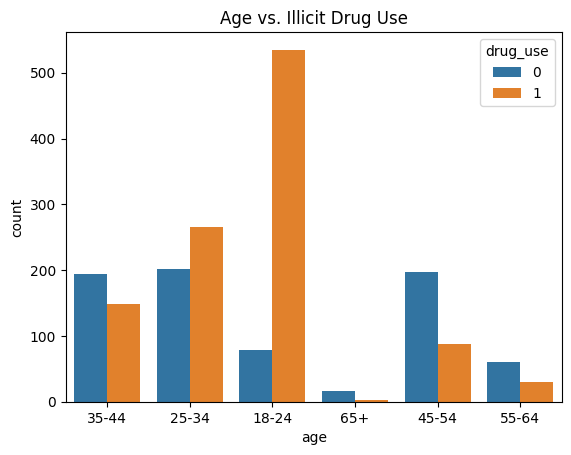

In [204]:
# Visualize age distribution by illicit drug use
sns.countplot(data=dfMapped, x='age', hue=df['drug_use'])
plt.title("Age vs. Illicit Drug Use")
plt.show()

Age seems to be very important, and young people are much more likely to be drug users as compared to older folks.

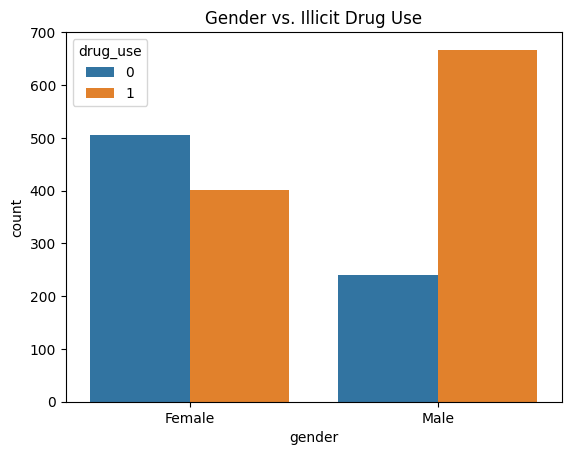

In [205]:
# Visualize gender distribution by illicit drug use
sns.countplot(data=dfMapped, x='gender', hue=df['drug_use'])
plt.title("Gender vs. Illicit Drug Use")
plt.show()

Gender is also a prevalent indicator with males using at much higher rates than females.

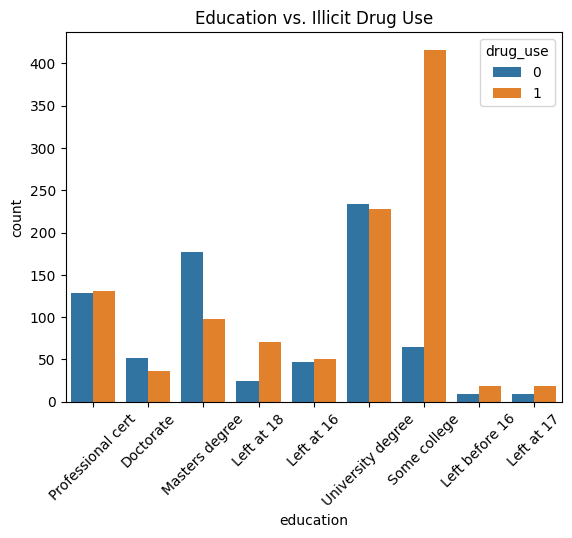

In [206]:
# Visualize education distribution by illicit drug use
sns.countplot(data=dfMapped, x='education', hue=df['drug_use'])
plt.title("Education vs. Illicit Drug Use")
plt.xticks(rotation=45)
plt.show()

Education is also correlated, with higher levels of education being tied to less drug use.

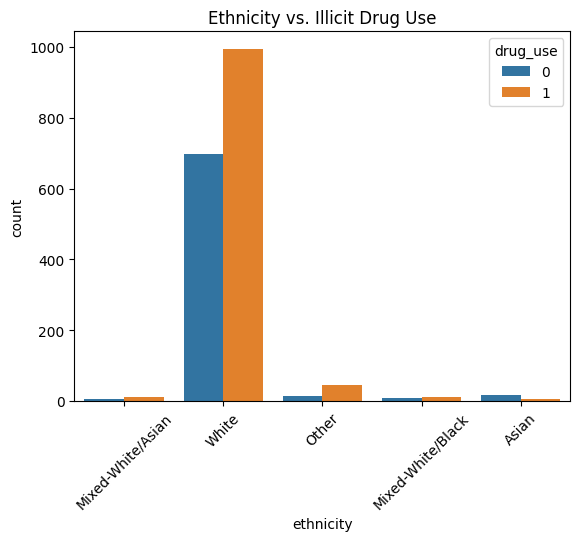

In [207]:
# Visualize ethnicity distribution by illicit drug use
sns.countplot(data=dfMapped, x='ethnicity', hue=df['drug_use'])
plt.title("Ethnicity vs. Illicit Drug Use")
plt.xticks(rotation=45)
plt.show()

Unclear if ethnicity plays a role given the extremely skewed dataset.

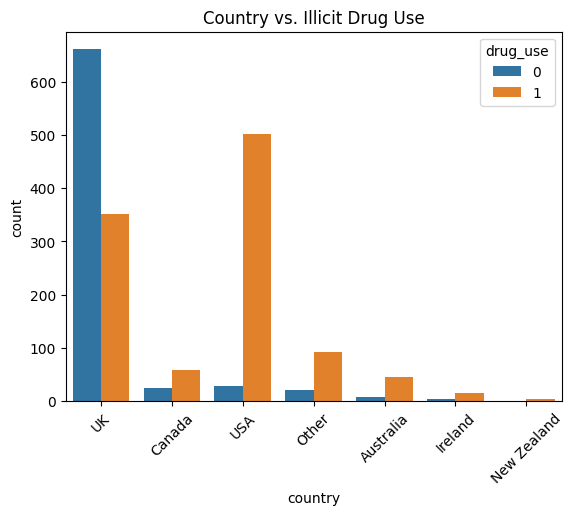

In [208]:
# Visualize country distribution by illicit drug use
sns.countplot(data=dfMapped, x='country', hue=df['drug_use'])
plt.title("Country vs. Illicit Drug Use")
plt.xticks(rotation=45)
plt.show()

Country does seem to be related with people from the UK not reporting as much drug use as the other countries.

b. Personality Traits

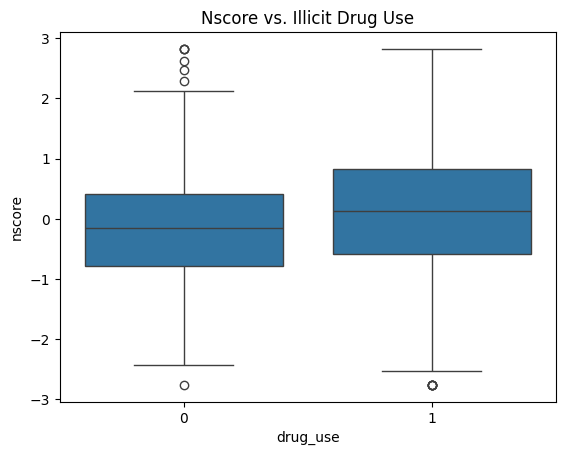

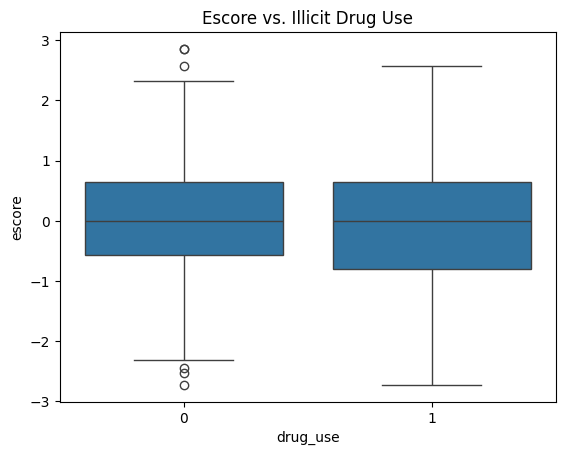

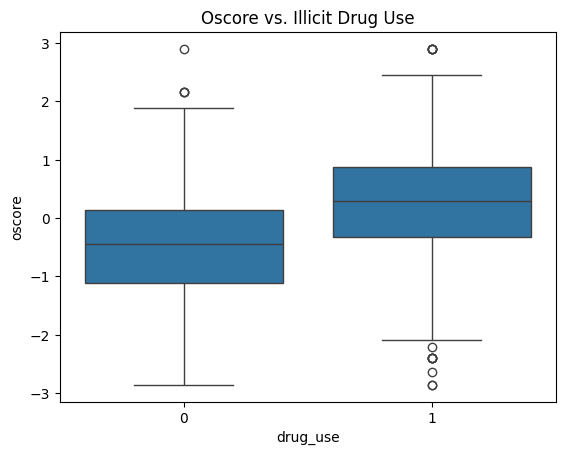

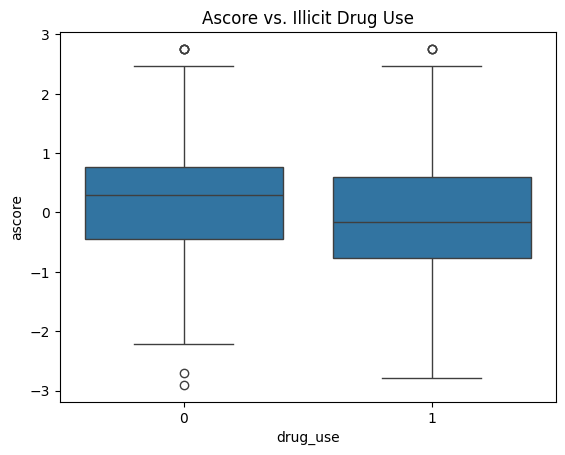

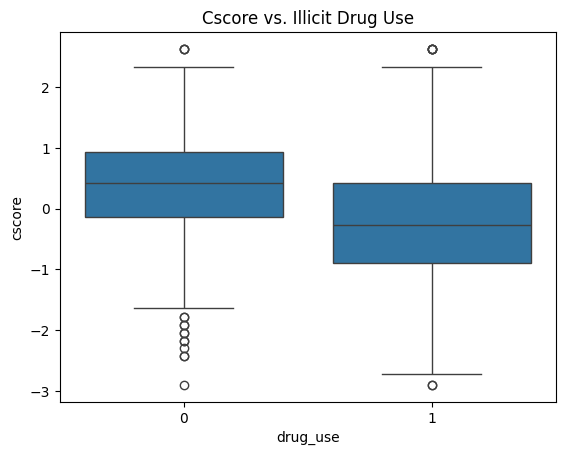

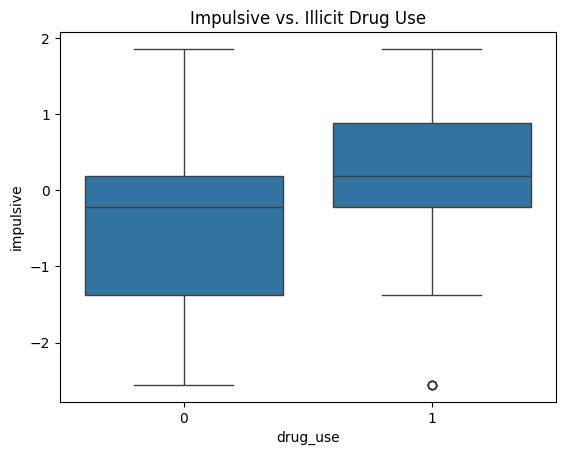

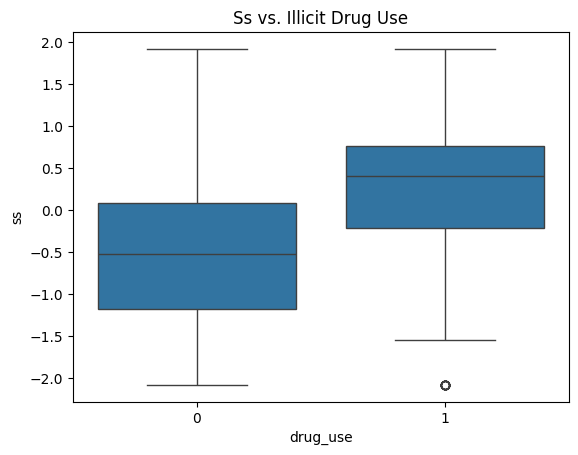

In [209]:
# Box plots for personality traits by illicit drug use
traits = ['nscore', 'escore', 'oscore', 'ascore', 'cscore', 'impulsive', 'ss']

for trait in traits:
    sns.boxplot(data=df, x=df['drug_use'], y=trait)
    plt.title(f"{trait.capitalize()} vs. Illicit Drug Use")
    plt.show()


c. Correlation Analysis

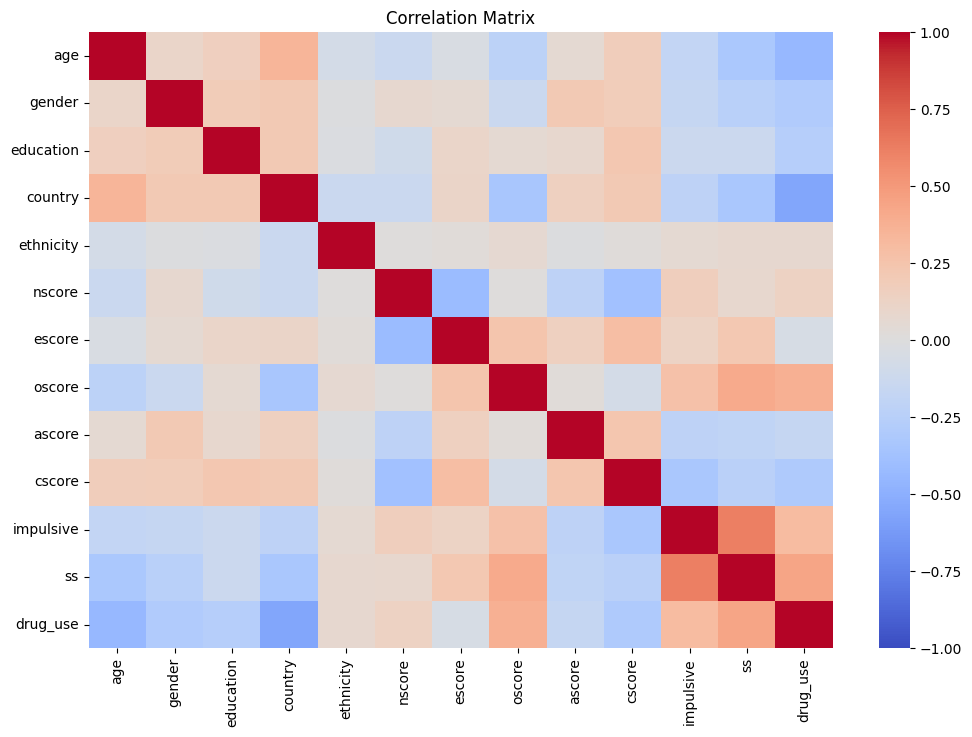

In [210]:
# Compute correlation matrix
correlation_matrix = dfDrugUse.corr()

# Plot heatmap for correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()


d. Pairwise Relationships

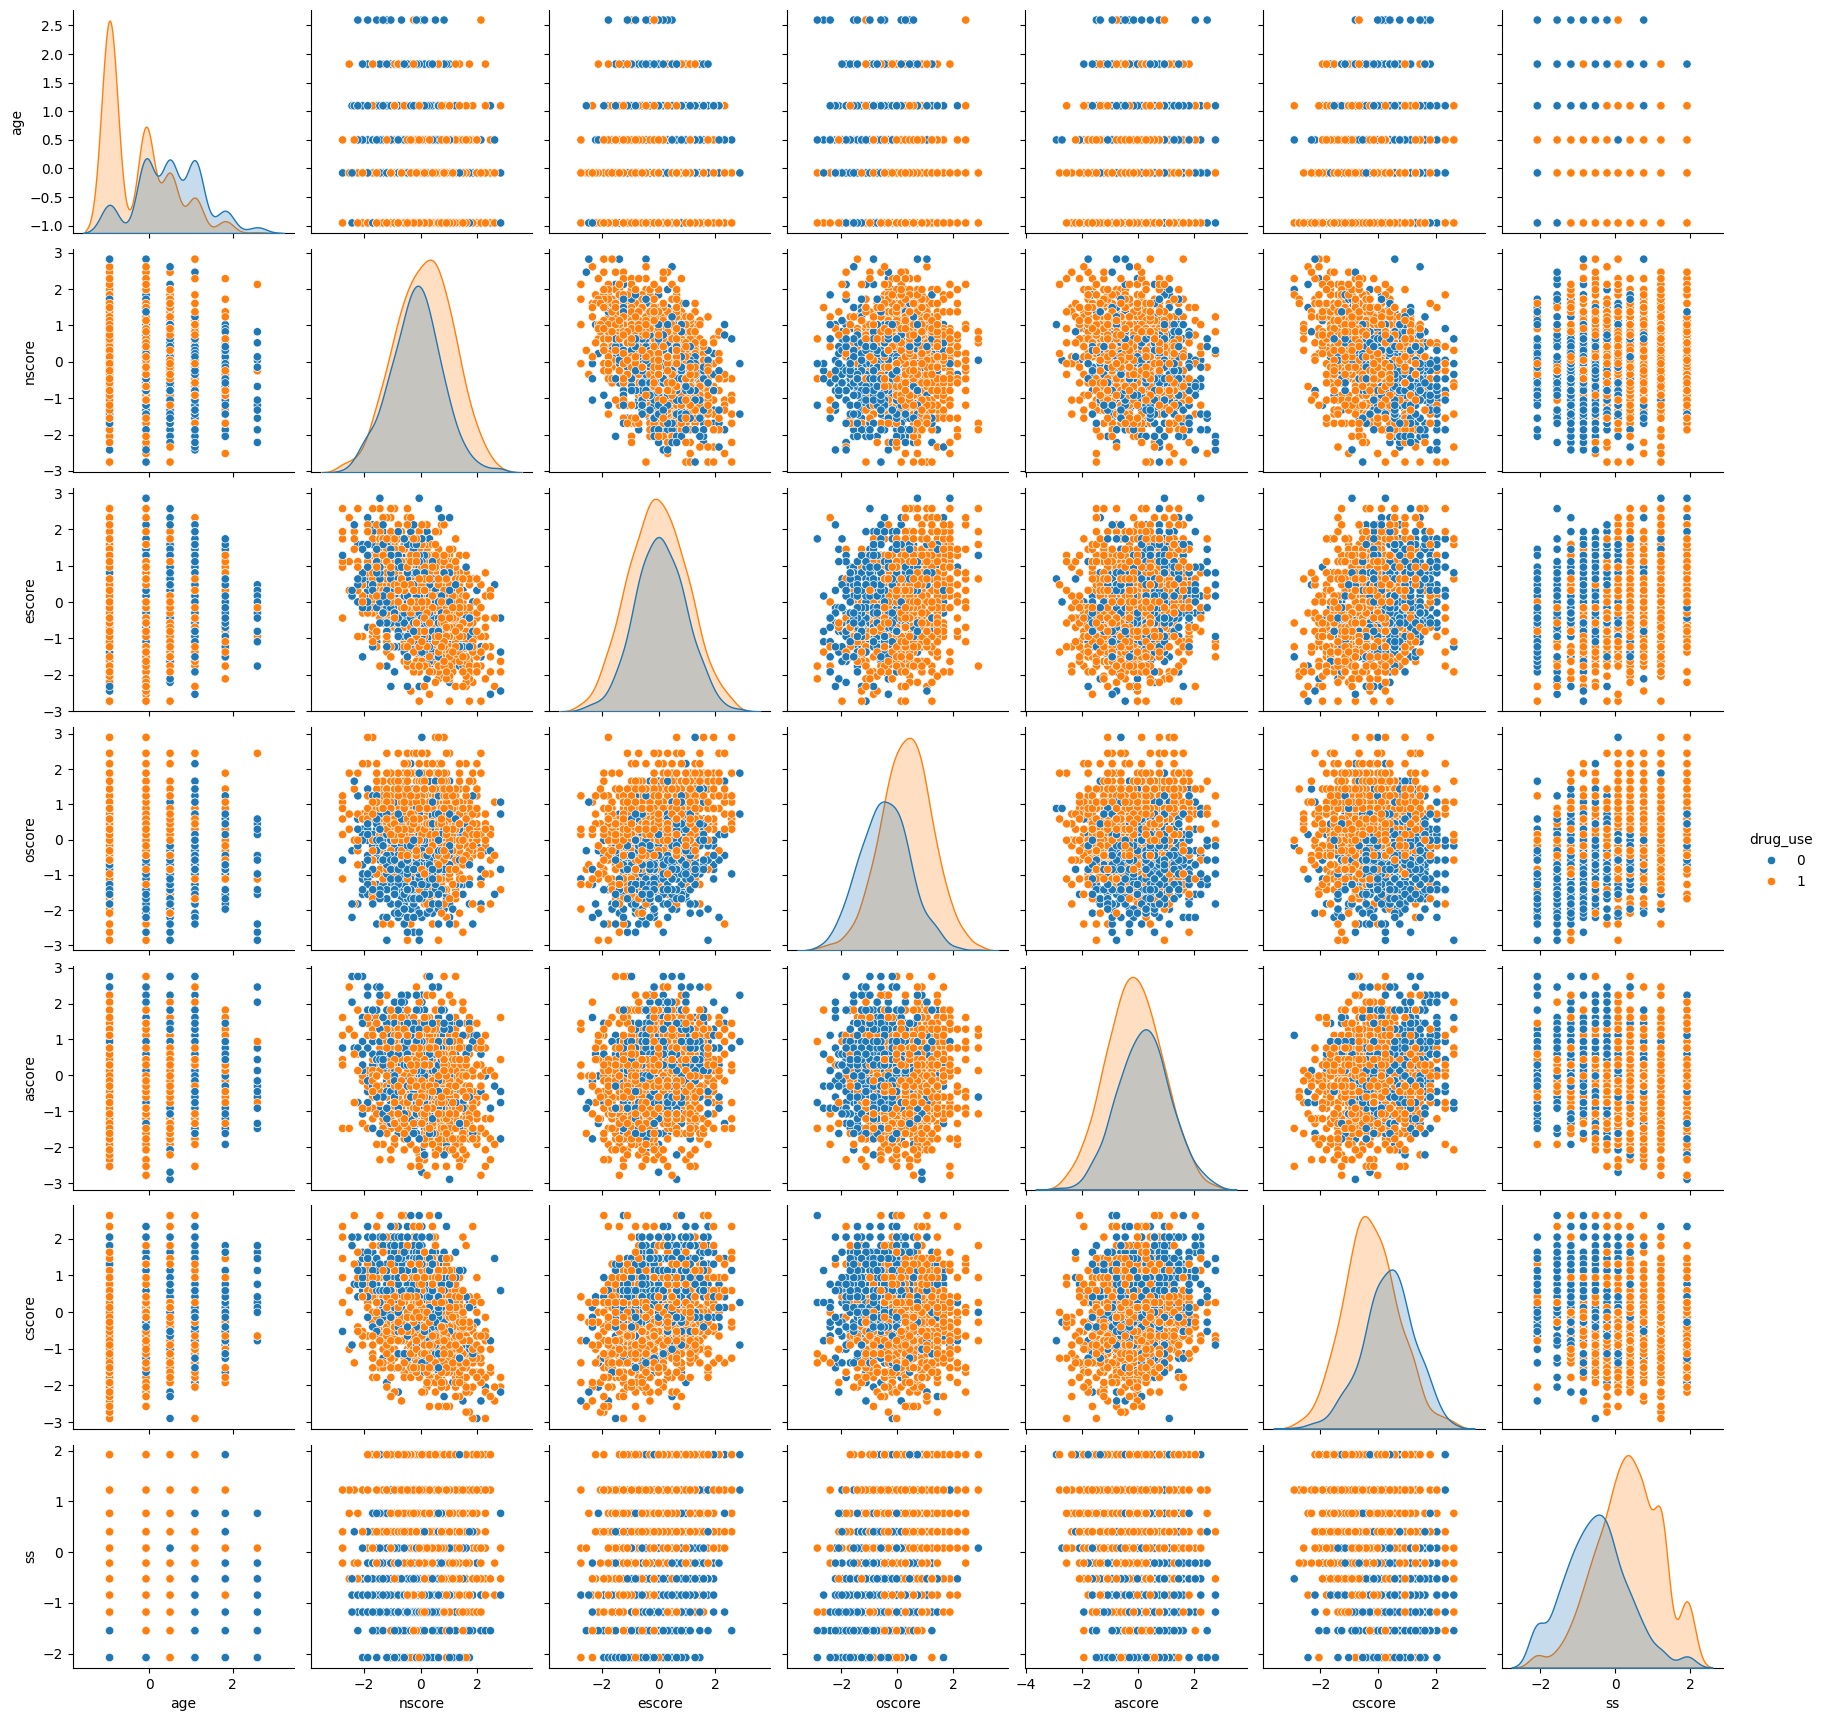

In [211]:
# Pair plot for selected features
selected_features = ['age', 'nscore', 'escore', 'oscore', 'ascore', 'cscore', 'drug_use','ss']
sns.pairplot(df[selected_features], hue='drug_use', diag_kind='kde')
plt.show()

High Openness, Sensation Seeking, Impulsivness, and Neuroticism are linked with drug use, and high Conscientiousness and Agreeableness are linked to non drug use. Extraversion does not seem to be relevant based on these visualizations. More detailed conversation about this to come when we introduce the different predictive models.

### **5.2 Findings**

-   **Younger individuals (18-24) have a higher proportion of drug use**.

-   **Males show higher drug use rates than females**.

-   **Lower education levels correlate with higher drug use prevalence**.

-   **Certain personality traits (e.g., high sensation-seeking score) correlate with higher drug use**.

**6\. Model Training and Evaluation**
-------------------------------------

### **6.1 Model Performance Metrics**

Each model was evaluated based on:

-   **Accuracy**

-   **Precision, Recall, and F1-score**

-   **ROC-AUC score**

-   **Confusion Matrix**

As a reminder we will be looking at the following models:

a.  **Logistic Regression**

b.  **Random Forest**

c.  **Support Vector Machine (SVM)** 

d.  **k-Nearest Neighbors (KNN)**

#### **a. Logistic Regression**

-   **Type**: Linear Model

-   **Best For**:

    -   Simple relationships between predictors and the target variable.
    -   Interpretable models with clear feature importance (via coefficients).
    -   Problems with linearly separable data.
-   **Pros**:

    -   Easy to implement and interpret.
    -   Computationally efficient and fast to train.
    -   Performs well with simple or moderately complex datasets.
    -   Naturally outputs probabilities for classification.
-   **Cons**:

    -   Assumes linearity between predictors and the target.
    -   Sensitive to multicollinearity among features.
    -   May struggle with non-linear decision boundaries.

In [213]:
# Define features (X) and target (y)
X = dfDrugUse.drop('drug_use', axis=1)  # Features
y = dfDrugUse['drug_use']       # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [214]:
# Initialize Logistic Regression model
logistic_model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42, class_weight='balanced')

# Train the model
logistic_model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')

In [215]:
# Predict on the test set
y_pred = logistic_model.predict(X_test)
y_proba = logistic_model.predict_proba(X_test)[:, 1]  # Probability estimates for ROC-AUC

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.91      0.81       150
           1       0.93      0.77      0.84       214

    accuracy                           0.83       364
   macro avg       0.83      0.84      0.83       364
weighted avg       0.85      0.83      0.83       364

Confusion Matrix:
[[137  13]
 [ 50 164]]


In [216]:
param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs']}
grid = GridSearchCV(LogisticRegression(max_iter=1000, class_weight='balanced'), param_grid, scoring='roc_auc', cv=3)
grid.fit(X_train, y_train)
best_params = grid.best_params_
print(f"Best Parameters: {grid.best_params_}")
print(f"Best ROC-AUC Score: {grid.best_score_}")

Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best ROC-AUC Score: 0.9085779776073348


In [217]:
best_logistic_model = LogisticRegression(**best_params, max_iter=1000, class_weight='balanced')
best_logistic_model.fit(X_train, y_train)
# Predict on the test set
y_pred = best_logistic_model.predict(X_test)
y_proba = best_logistic_model.predict_proba(X_test)[:, 1]  # Probability estimates for ROC-AUC

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.90      0.81       150
           1       0.92      0.77      0.84       214

    accuracy                           0.82       364
   macro avg       0.83      0.84      0.82       364
weighted avg       0.84      0.82      0.83       364

Confusion Matrix:
[[135  15]
 [ 49 165]]


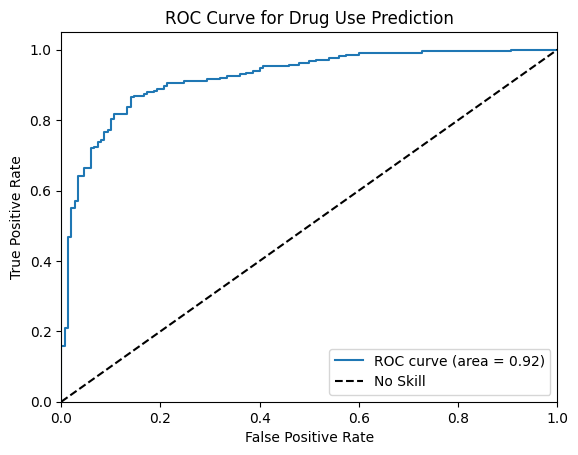

In [218]:
# Predict probabilities on the test set
y_pred_proba = best_logistic_model.predict_proba(X_test)[:, 1] 

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Drug Use Prediction')
plt.legend()
plt.show()

/var/folders/mz/8ggffgss3v39bd1rmk8kb1sh0000gr/T/ipykernel_4391/1769634574.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=logistic_feature_df['Importance'], y=logistic_feature_df['Feature'], palette="Blues_r")


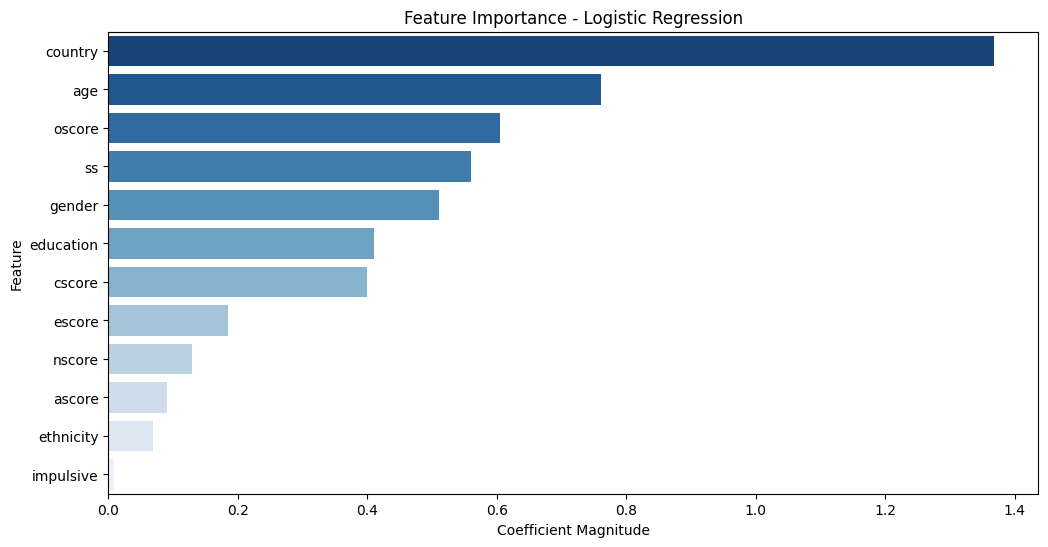

In [219]:
# Get feature importance from Logistic Regression (absolute coefficient values)
logistic_feature_importance = abs(best_logistic_model.coef_[0])

# Convert to DataFrame
logistic_feature_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': logistic_feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=logistic_feature_df['Importance'], y=logistic_feature_df['Feature'], palette="Blues_r")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature")
plt.title("Feature Importance - Logistic Regression")
plt.show()

Coutry, Age, Openness, and Sensation Seeking scores tend to be the strongest predictors of drug use.

#### **b. Random Forest**

-   **Type**: Ensemble Model (Bagging)

-   **Best For**:

    -   Complex, non-linear relationships.
    -   Handling missing data and unbalanced datasets.
    -   Feature importance analysis.
-   **Pros**:

    -   Can capture non-linear patterns and interactions between features.
    -   Robust to overfitting with enough trees.
    -   Automatically handles feature scaling and normalization.
    -   Resistant to outliers and noise.
-   **Cons**:

    -   Can be slower to train for large datasets.
    -   Interpretability is lower compared to simpler models like Logistic Regression.
    -   May require hyperparameter tuning (e.g., number of trees, max depth) for optimal performance.

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    random_state=42,
    class_weight='balanced',  # Handle class imbalance
    max_depth=None,  # Allow trees to grow fully
)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [221]:
# Predict on the test set
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability estimates for ROC-AUC

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       150
           1       0.90      0.85      0.87       214

    accuracy                           0.85       364
   macro avg       0.85      0.85      0.85       364
weighted avg       0.85      0.85      0.85       364

ROC-AUC Score: 0.9063239875389408
Confusion Matrix:
[[129  21]
 [ 33 181]]


In [222]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=2
)
grid_search.fit(X_train, y_train)

# Best parameters and score
best_params = grid_search.best_params_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best ROC-AUC Score: {grid_search.best_score_}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best ROC-AUC Score: 0.9086249963266626


In [223]:
best_rf_model = RandomForestClassifier(**best_params, random_state=42, class_weight='balanced')

# Train the model
best_rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=300, random_state=42)

In [224]:
# Predict on the test set
y_pred = best_rf_model.predict(X_test)
y_proba = best_rf_model.predict_proba(X_test)[:, 1]  # Probability estimates for ROC-AUC

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       150
           1       0.90      0.80      0.85       214

    accuracy                           0.83       364
   macro avg       0.83      0.84      0.83       364
weighted avg       0.84      0.83      0.83       364

ROC-AUC Score: 0.9089096573208724
Confusion Matrix:
[[130  20]
 [ 42 172]]


In [225]:
# Get feature importance from the best Random Forest model
feature_importance = best_rf_model.feature_importances_

# Convert to DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)  # Sort by importance

# Display top features
print(feature_importance_df.head(10))  # Show top 10 most important features

      Feature  Importance
3     country    0.275245
0         age    0.135917
11         ss    0.133238
7      oscore    0.108092
9      cscore    0.082219
2   education    0.073912
5      nscore    0.043645
8      ascore    0.040105
10  impulsive    0.038265
6      escore    0.036824


Aligned with what we found in the logistic regression: Country, Age, Openness, and Sensation Seeking scores are the most important predictors of drug use.

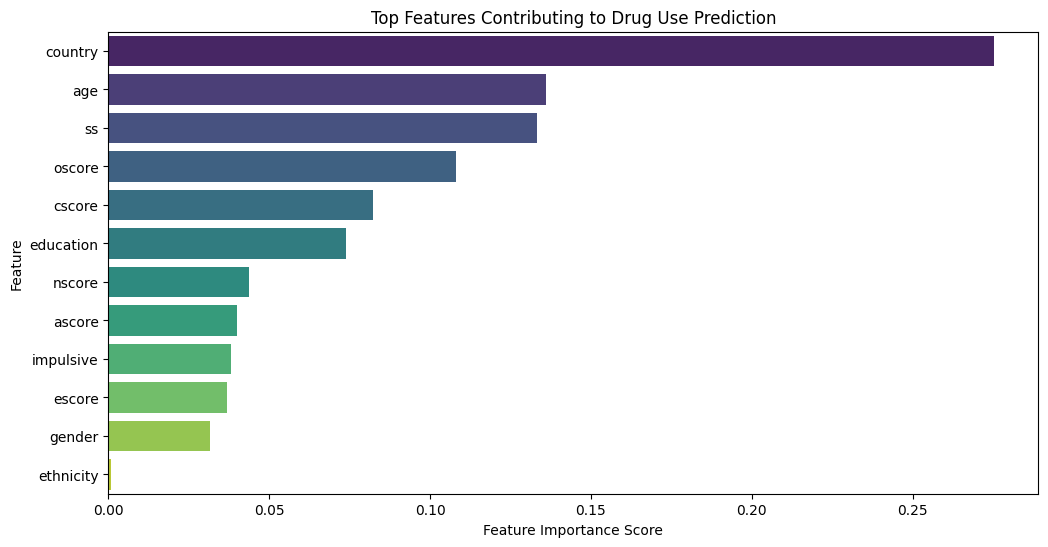

In [226]:
# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance_df['Importance'], 
            y=feature_importance_df['Feature'], 
            hue=feature_importance_df['Feature'],  # Assigning `y` to `hue`
            palette="viridis", 
            legend=False)  # Disable legend as it's unnecessary

# Labels and title
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Top Features Contributing to Drug Use Prediction")
plt.show()

#### **c. Support Vector Machine (Soft Margin)**

-   **Type**: Kernel-based Model

-   **Best For**:

    -   High-dimensional data.
    -   Non-linear decision boundaries (via kernel functions).
    -   Problems where a soft margin (allowing some misclassifications) is beneficial.
-   **Pros**:

    -   Effective for high-dimensional spaces and small datasets.
    -   Can model complex relationships using kernels (e.g., radial basis function, polynomial).
    -   Well-suited for imbalanced datasets with proper tuning (e.g., class weights).
-   **Cons**:

    -   Computationally expensive for large datasets.
    -   Sensitive to the choice of hyperparameters (e.g., kernel type, `C` parameter).
    -   Less interpretable compared to Logistic Regression or Random Forest.

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train SVM with default hyperparameters
svm_model = SVC(C=1.0, kernel='rbf', gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Cross-validation
scores = cross_val_score(svm_model, X_train, y_train, cv=3)
print("Cross-validation mean accuracy: {:.3f}".format(np.mean(scores)))


Cross-validation mean accuracy: 0.832


In [228]:
# Predict on the test set
y_pred = svm_model.predict(X_test)
y_proba = svm_model.decision_function(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc}")


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       150
           1       0.89      0.84      0.86       214

    accuracy                           0.84       364
   macro avg       0.84      0.84      0.84       364
weighted avg       0.85      0.84      0.84       364

Confusion Matrix:
[[127  23]
 [ 34 180]]
ROC-AUC Score: 0.9021183800623052


In [229]:
# Define hyperparameter grid for SVM
svm_param_grid = {
    'C': np.logspace(-3, 3, 7),  # Try values from 0.001 to 1000
    'gamma': np.logspace(-3, 3, 7),  # Try values from 0.001 to 1000
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']  # Test kernels
}

# GridSearch for SVM
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_param_grid, cv=3, scoring='roc_auc', verbose=1)
svm_grid.fit(X_train, y_train)

# Best SVM model
best_svm = svm_grid.best_estimator_

# Print best parameters
print(f"Best Parameters for SVM: {svm_grid.best_params_}")

# Evaluate on test set
y_pred_svm = best_svm.predict(X_test)
y_proba_svm = best_svm.decision_function(X_test)

# Performance metrics
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix for SVM:")
print(conf_matrix_svm)

# ROC-AUC Score
roc_auc_svm = roc_auc_score(y_test, y_proba_svm)
print(f"SVM ROC-AUC Score: {roc_auc_svm:.3f}")

Fitting 3 folds for each of 196 candidates, totalling 588 fits
Best Parameters for SVM: {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       150
           1       0.91      0.79      0.84       214

    accuracy                           0.83       364
   macro avg       0.83      0.84      0.83       364
weighted avg       0.84      0.83      0.83       364

Confusion Matrix for SVM:
[[133  17]
 [ 45 169]]
SVM ROC-AUC Score: 0.921


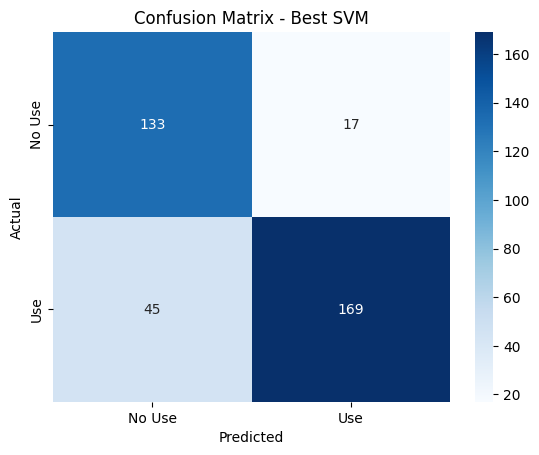

In [230]:
# Confusion matrix for the best model
conf_matrix_best = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', xticklabels=['No Use', 'Use'], yticklabels=['No Use', 'Use'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Best SVM')
plt.show()

#### **d. k-Nearest Neighbors (kNN)**

-   **Type**: Instance-based Learning

-   **Best For**:

    -   Simple datasets with clear clusters or patterns.
    -   When interpretability isn't a priority but simplicity is.
-   **Pros**:

    -   Easy to implement.
    -   Makes no assumptions about the data distribution.
    -   Adapts naturally to non-linear decision boundaries.
-   **Cons**:

    -   Computationally expensive for large datasets.
    -   Sensitive to irrelevant features and feature scaling.
    -   Performance depends heavily on the choice of `k`.

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize KNN with K=3
knn = KNeighborsClassifier(n_neighbors=3)

# Train the model
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Evaluate the model
print("Classification Report for K=3:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix for K=3:")
print(conf_matrix)

Classification Report for K=3:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       150
           1       0.88      0.81      0.84       214

    accuracy                           0.82       364
   macro avg       0.82      0.83      0.82       364
weighted avg       0.83      0.82      0.83       364

Confusion Matrix for K=3:
[[126  24]
 [ 40 174]]


In [232]:
# Define hyperparameter grid for KNN
knn_param_grid = {
    'n_neighbors': range(1, 50, 2),  # Test odd values from 1 to 49
    'weights': ['uniform', 'distance'],  # Test both uniform and distance-based weighting
    'metric': ['euclidean', 'manhattan']  # Test different distance metrics
}

# GridSearch for KNN
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=3, scoring='roc_auc', verbose=1)
knn_grid.fit(X_train, y_train)

# Best KNN model
best_knn = knn_grid.best_estimator_

# Print best parameters
best_params_knn = knn_grid.best_params_
print(f"Best Parameters for KNN: {best_params_knn}")

# Evaluate on test set
y_pred_knn = best_knn.predict(X_test)
y_proba_knn = best_knn.predict_proba(X_test)[:, 1]

# Performance metrics
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Confusion Matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix for KNN:")
print(conf_matrix_knn)

# ROC-AUC Score
roc_auc_knn = roc_auc_score(y_test, y_proba_knn)
print(f"KNN ROC-AUC Score: {roc_auc_knn:.3f}")

# Train KNN with dynamically determined optimal parameters
knn_optimal = KNeighborsClassifier(**best_params_knn)
knn_optimal.fit(X_train, y_train)

# Predict on the test set
y_pred_optimal = knn_optimal.predict(X_test)

# Evaluate the optimal KNN model
print(f"Classification Report for Optimal KNN Model:")
print(classification_report(y_test, y_pred_optimal))

# Confusion matrix for optimal KNN
conf_matrix_optimal = confusion_matrix(y_test, y_pred_optimal)
print("Confusion Matrix for Optimal KNN Model:")
print(conf_matrix_optimal)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 49, 'weights': 'distance'}
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.89      0.82       150
           1       0.91      0.79      0.85       214

    accuracy                           0.84       364
   macro avg       0.83      0.84      0.83       364
weighted avg       0.85      0.84      0.84       364

Confusion Matrix for KNN:
[[134  16]
 [ 44 170]]
KNN ROC-AUC Score: 0.913
Classification Report for Optimal KNN Model:
              precision    recall  f1-score   support

           0       0.75      0.89      0.82       150
           1       0.91      0.79      0.85       214

    accuracy                           0.84       364
   macro avg       0.83      0.84      0.83       364
weighted avg       0.85      0.84      0.84       364

Confusion Matrix for Optimal KNN Model:
[[134 

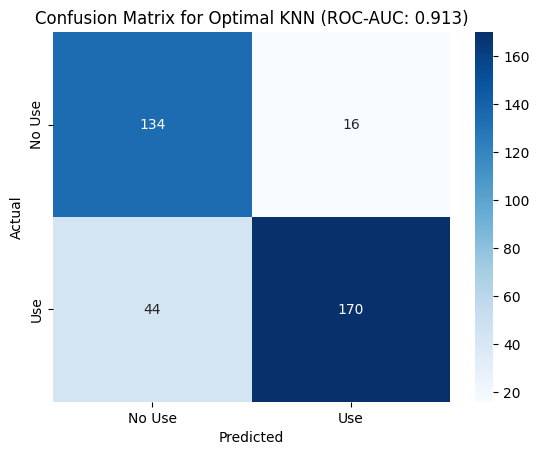

In [233]:
# Confusion matrix heatmap
sns.heatmap(conf_matrix_optimal, annot=True, fmt='d', cmap='Blues', xticklabels=['No Use', 'Use'], yticklabels=['No Use', 'Use'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for Optimal KNN (ROC-AUC: {roc_auc_knn:.3f})')
plt.show()

### **6.2 Results**

Let's visualize the results below

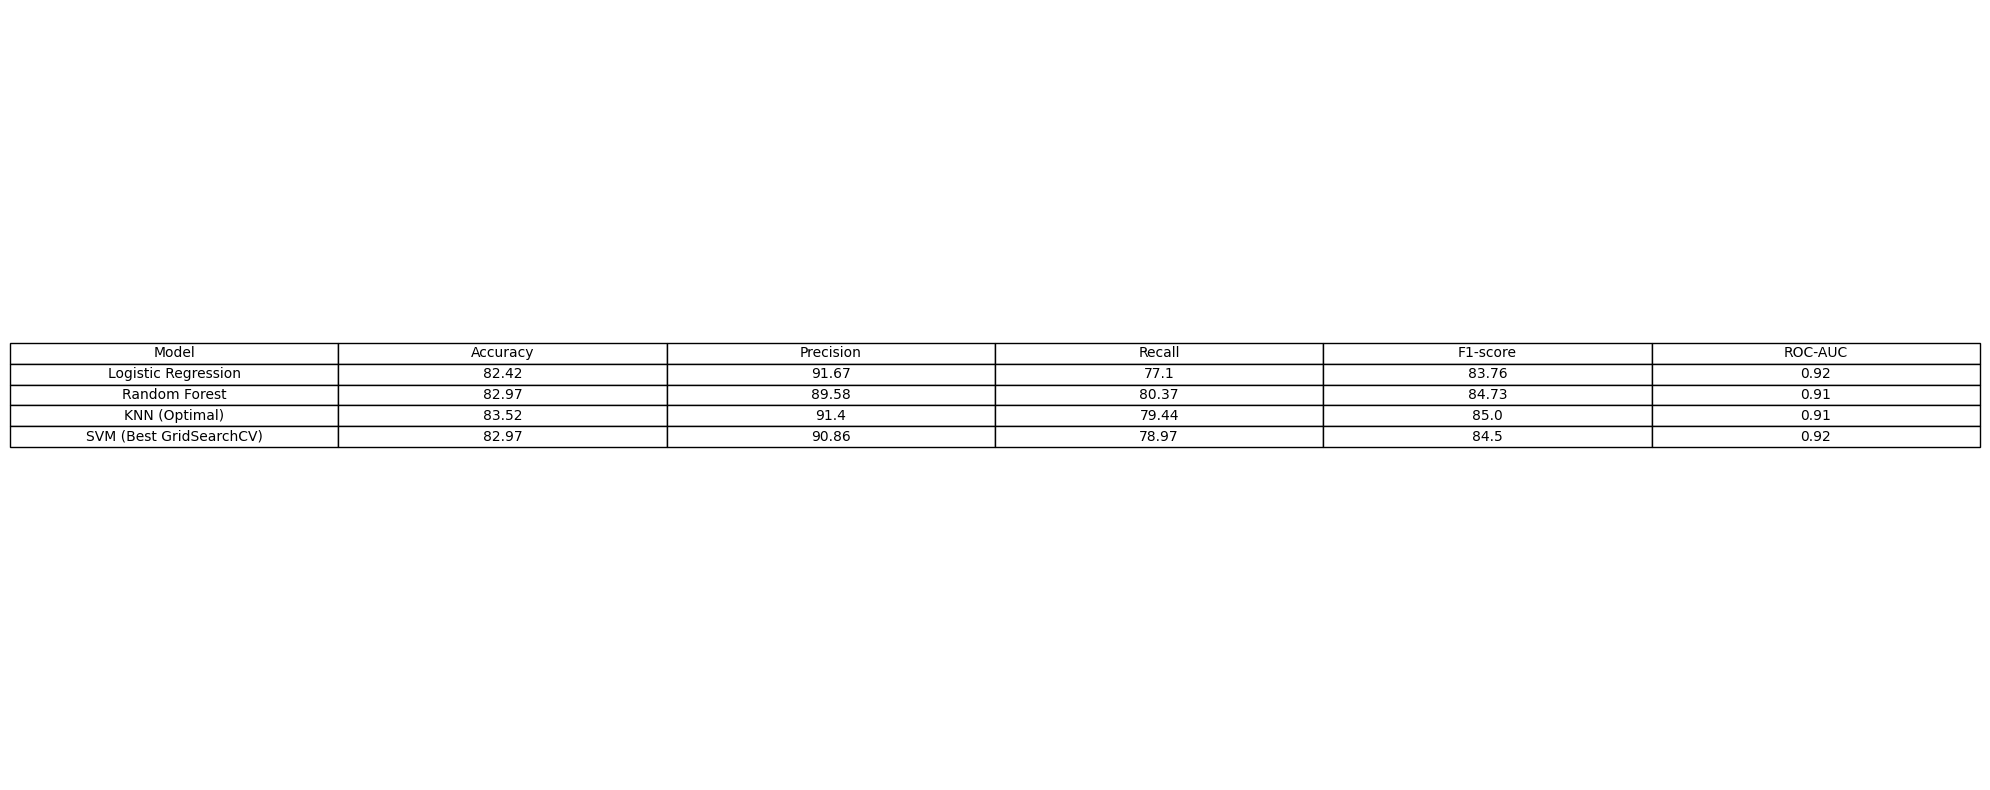

In [234]:
# Initialize a list to store model results
model_results = []

# Function to evaluate a model and store metrics
def evaluate_model(model_name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # Handle probability-based vs. decision function-based models
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
    else:
        y_proba = None

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else "N/A"

    # Append to results
    model_results.append({
        "Model": model_name,
        "Accuracy": round(accuracy * 100, 2),
        "Precision": round(precision * 100, 2),
        "Recall": round(recall * 100, 2),
        "F1-score": round(f1 * 100, 2),
        "ROC-AUC": round(roc_auc, 2) if roc_auc != "N/A" else "N/A"
    })

# Evaluate each model dynamically
evaluate_model("Logistic Regression", best_logistic_model, X_test, y_test)
evaluate_model("Random Forest", best_rf_model, X_test, y_test)
evaluate_model("KNN (Optimal)", best_knn, X_test, y_test)
evaluate_model("SVM (Best GridSearchCV)", best_svm, X_test, y_test)

# Convert results to DataFrame
model_df = pd.DataFrame(model_results)

# Display the table dynamically
fig, ax = plt.subplots(figsize=(20, 8))  # Adjust figsize to fit the table
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=model_df.values, colLabels=model_df.columns, cellLoc='center', loc='center')

# Adjust layout to minimize white space
plt.tight_layout()

# Show the plot
plt.show()